In [ ]:
!pip install zxing
!pip install qrcode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.1/680.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import types
from google.colab.patches import cv2_imshow
from google.colab import drive
import base64
import qrcode
import numpy as np
import os
import zxing
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding
import cv2

In [ ]:
# Constants for file paths
PRIVATE_KEY_FILE_PATH = "recipient_private_key.pem"
PUBLIC_KEY_FILE_PATH = "recipient_public_key.pem"

In [ ]:
# Function to convert base64 encoding back to an image
def base64_to_image(base64_str, output_path):
    image_bytes = base64.b64decode(base64_str)
    image_nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(image_nparr, cv2.IMREAD_COLOR)
    cv2.imwrite(output_path, image)
    return output_path

In [ ]:
# Function to convert an image to base64 encoding
def image_to_base64(img_path, resize_dim=(25, 25)):

    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, resize_dim)

    # Convert the image to base64
    _, buffer = cv2.imencode('.jpg', image_resized)
    image_base64 = base64.b64encode(buffer).decode('utf-8')

    return image_base64

In [ ]:
# Function to generate an RSA key pair
def generate_rsa_key_pair():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    public_key = private_key.public_key()
    return private_key, public_key

In [ ]:
# Function to generate an RSA key pair and save to disk
def generate_and_save_rsa_key_pair():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    public_key = private_key.public_key()

    # Save private key to file
    with open(PRIVATE_KEY_FILE_PATH, "wb") as key_file:
        key_file.write(private_key.private_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PrivateFormat.PKCS8,
            encryption_algorithm=serialization.NoEncryption()
        ))

    # Save public key to file
    with open(PUBLIC_KEY_FILE_PATH, "wb") as key_file:
        key_file.write(public_key.public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        ))

    return private_key, public_key


In [ ]:

def load_rsa_key_pair_from_disk():
    # Load private key from file
    with open(PRIVATE_KEY_FILE_PATH, "rb") as key_file:
        private_key = serialization.load_pem_private_key(
            key_file.read(),
            password=None,
            backend=default_backend()
        )

    # Load public key from file
    with open(PUBLIC_KEY_FILE_PATH, "rb") as key_file:
        public_key = serialization.load_pem_public_key(
            key_file.read(),
            backend=default_backend()
        )

    return private_key, public_key

In [ ]:
# Function to encrypt a message with the recipient's public key
def encrypt_message(message, recipient_public_key):
    ciphertext = recipient_public_key.encrypt(
        message.encode('utf-8'),
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return base64.b64encode(ciphertext).decode('utf-8')

In [ ]:
# Function to create a QR code from a message
def generate_qr_code(message, filename):
    qr = qrcode.QRCode(
        version=None,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(message)
    qr.make(fit=True)
    qr_img_path = filename
    qr_img = qr.make_image(fill_color="black", back_color="white")
    qr_img.save(qr_img_path)
    return qr_img_path

In [ ]:
# function to embed the image within the QR code
def generate_qr_code_with_image(message, image_path, filename):
    image_base64 = image_to_base64(image_path)
    combined_data = image_base64 + "|||" + message  # Use a separator to differentiate the image and message
    return generate_qr_code(combined_data, filename)

In [ ]:
# Function to read QR code from an image file and return the decoded data
def decode_qr_with_zxing(image_path):
    reader = zxing.BarCodeReader()
    barcode = reader.decode(image_path)
    if barcode is not None:
        return barcode.raw
    return None


In [ ]:
# function to extract the image and message from the QR code
def decode_qr_code_with_image(filename):
    decoded_data = decode_qr_with_zxing(filename)
    # print(decoded_data.count("|||"))
    if "|||" not in decoded_data:
        raise ValueError("The decoded data does not contain the expected separator.")
    image_base64, encrypted_message = decoded_data.split("|||")  # Use the separator to split the data
    image_path = base64_to_image(image_base64, "extracted_watermark_image.png")
    return image_path, encrypted_message

In [ ]:
# Function to decrypt a message with the recipient's private key
def decrypt_message(encrypted_message_base64, recipient_private_key):
    ciphertext = base64.b64decode(encrypted_message_base64)
    plaintext = recipient_private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return plaintext.decode('utf-8')

In [ ]:
#to convert the different types into binary
def messageToBinary(message):
  if (isinstance(message, str)):
    return ''.join([format(ord(i),'08b') for i in message])
  elif (isinstance(message, bytes) or isinstance(message, np.ndarray)):
    return [format(i,'08b') for i in message]
  elif (isinstance(message, int) or isinstance(message, np.uint8)):
    return format(message,'08b')
  else:
    raise TypeError('Input Type Not Supported')

In [ ]:
#to hide secret msg into image
def hideData(image,secret_message):

  #maximum bytes to encode
  n_bytes = image.shape[0] * image.shape[1] * 3 // 8
  print('Maximum bytes to encode:',n_bytes)

  #if the number of bytes to encode is less than the maximum bytes in the image
  if (len(secret_message) > n_bytes):
    raise ValueError('Error encountered insufficient bytes, need bigger image or less data!!')
  secret_message += '#####' #string as a delimeter/separator
  data_index = 0

  #convert input data to binary format using messageToBinary()
  binary_secret_msg = messageToBinary(secret_message)
  data_len = len(binary_secret_msg)
  print(data_len)

  for values in image:
    for pixel in values:
      #convert rgb values to binary format
      r, g, b  = messageToBinary(pixel)

      #modify the lsb only if there is
      if (data_index < data_len):
        #hide the data into lsb of red pixel
        pixel[0] = int (r[:-1] + binary_secret_msg[data_index], 2)
        data_index += 1
      if (data_index < data_len):
        #hide the data into lsb of green pixel
        pixel[1] = int (g[:-1] + binary_secret_msg[data_index], 2)
        data_index += 1
      if (data_index < data_len):
        #hide the data into lsb of blue pixel
        pixel[2] = int (b[:-1] + binary_secret_msg[data_index], 2)
        data_index += 1

      #if all data is embedded
      if (data_index >= data_len):
        break
  # print(data_index)
  return image

In [ ]:
def showData(image):
  binary_data = ''
  for values in image:
    for pixel in values:
      r, g, b = messageToBinary(pixel) #convert the red, green and blue values intpo binary format
      binary_data += r[-1] #extracting data from the lsb of red pixel
      binary_data += g[-1] #extraxting data from the lsb of green pixel
      binary_data += b[-1] #extracting data from the lsb of blue pixel
  # print(binary_data)
  #split by 8 bits
  all_bytes = [ binary_data[i: i+8] for i in range(0,len(binary_data),8)]
  #convert from bits into characters
  decoded_data = ''
  for byte in all_bytes:
    decoded_data += chr( int (byte,2))
    if (decoded_data[-5:] == '#####'): #separoator reached
      break
  print(decoded_data)
  return decoded_data[:-5]

In [ ]:
#encode data into image
def encode_text():
  watermark_image_name = input('Enter watermark image name(with extension): ')
  image_name = input('Enter the image name(with extension): ')
  secret_message = input("Enter Secret Message to be embedded : ")
  image = cv2.imread(image_name)

  print("The shape of the image is: ",image.shape)
  print("The original image is as shown below: ")
  resized_image = cv2.resize(image, (100, 100))
  cv2_imshow(resized_image) #display the image

  qr_img_path = generate_qr_code_with_image(encrypt_message(secret_message, public_key), watermark_image_name, "qr_code_with_image.png")
  qr_img = cv2.imread(qr_img_path)
  qr_resized = cv2.resize(qr_img, (100, 100))
  cv2_imshow(qr_resized)

  extracted_image_path, encrypted_message_base64_with_image = decode_qr_code_with_image(qr_img_path)
  print(encrypted_message_base64_with_image)

  if (len(encrypted_message_base64_with_image) == 0):
    raise ValueError('Data is empty')

  filename = input("Enter the name of new encoded image(with extension): ")
  encoded_image = hideData(image, encrypted_message_base64_with_image) #embed
  cv2.imwrite(filename, encoded_image)


In [ ]:
#Decode the data in the image
def decode_text():

  image_name = input('Enter the name of the steganographed image that you want to decode (with extension): ')
  image = cv2.imread(image_name)
  watermark_image = cv2.imread("extracted_watermark_image.png")
  print("The Steganographed image is as shown below: ")
  watermark_image = cv2.resize(watermark_image, (100, 100))
  cv2_imshow(watermark_image) #display the Steganographed image
  text = decrypt_message(showData(image),private_key)
  return text

In [ ]:
#Peak to noise ratio - compares quality of image
def psnr(orig, watermarked):
    mse = np.mean((orig - watermarked) ** 2)
    if(mse == 0):
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

In [ ]:
#Normalized Cross-Correlation - compares the similarity between images
def ncc(orig, stego):
    mean_orig = np.mean(orig)
    mean_stego = np.mean(stego)
    norm_orig = orig - mean_orig
    norm_stego = stego - mean_stego
    ncc = (np.mean(norm_orig * norm_stego)) / (np.std(norm_orig) * np.std(norm_stego))
    return ncc

In [ ]:

def LSB():
    a = input("Digital Image Watermarking \n 1. Embed the data \n 2. Extract the data \n Your input is: ")
    userinput = int(a)
    if (userinput == 1):
      print("\nEmbedding....")
      encode_text()

    elif (userinput == 2):
      print("\nExtracting....")
      print("Decoded message is " + decode_text())
      image_name = cv2.imread("cat.jpg")
      encoded_image = cv2.imread("w_lsb.png")
      psnr_value = psnr(image_name, encoded_image)
      print(f"PSNR between original and LSB encoded image: {psnr_value:.2f} dB")

      ncc_value = ncc(image_name, encoded_image)
      print(f"NCC value is: {ncc_value:.4f}")
    else:
        raise Exception("Enter correct input")

# Check if the key files already exist
if not os.path.exists(PRIVATE_KEY_FILE_PATH) or not os.path.exists(PUBLIC_KEY_FILE_PATH):
    # Generate and save RSA key pair if not already saved
    print("KEYS DOES NOT EXIST")
    private_key, public_key = generate_and_save_rsa_key_pair()
else:
    # Load RSA key pair from disk
    print("KEYS ALREADY EXIST")
    private_key, public_key = load_rsa_key_pair_from_disk()

# Encrypt the message with the recipient's public key (recipient's public key should be known to the sender)
recipient_public_key_pem = public_key.public_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PublicFormat.SubjectPublicKeyInfo
).decode('utf-8')


KEYS ALREADY EXIST


Digital Image Watermarking 
 1. Embed the data 
 2. Extract the data 
 Your input is: 1

Embedding....
Enter watermark image name(with extension): watermark.jpg
Enter the image name(with extension): cat.jpg
Enter Secret Message to be embedded : Operation Nightfall: Commence covert infiltration of target location at 02:00 hours. Establish communication relay and await further instructions.
The shape of the image is:  (354, 500, 3)
The original image is as shown below: 


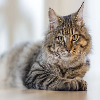

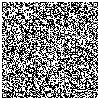

MYsGpiMQh9CPKs6jLVxIA0+gbrVDmKnSgvzumIerVO42ai7wcDC2WOhi54MWP/Icp+yag1eYTx6o550oInpHNTkzjD7UxlUFEBhTdc19ZD+xFpCGTUY8cVL/Qp0Y0NZzX7iNI5kntvXbW48bW5ktlMsJ7+Ey+X9iYrC8YxE4U8pMtY/jZaqgWf3wBp0G/cDEhbxGOop9Ye7DWZTz77UfCnZ5PXalkwyDPAa1hhJMnpPSVWa0jMzIUPZXwTXEhuhUicK0jziJPiXtREatWFL1gPRnjyhtT+BBkNmVaKgf0k6t9SdDt8hhdFSblg4FoRR1YKPv0ArC3IF11mGBivfCLQ==
Enter the name of new encoded image(with extension): w_lsb.png
Maximum bytes to encode: 66375
2792


In [ ]:
LSB() #embed image

Digital Image Watermarking 
 1. Embed the data 
 2. Extract the data 
 Your input is: 2

Extracting....
Enter the name of the steganographed image that you want to decode (with extension): w_lsb.png
The Steganographed image is as shown below: 


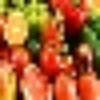

MYsGpiMQh9CPKs6jLVxIA0+gbrVDmKnSgvzumIerVO42ai7wcDC2WOhi54MWP/Icp+yag1eYTx6o550oInpHNTkzjD7UxlUFEBhTdc19ZD+xFpCGTUY8cVL/Qp0Y0NZzX7iNI5kntvXbW48bW5ktlMsJ7+Ey+X9iYrC8YxE4U8pMtY/jZaqgWf3wBp0G/cDEhbxGOop9Ye7DWZTz77UfCnZ5PXalkwyDPAa1hhJMnpPSVWa0jMzIUPZXwTXEhuhUicK0jziJPiXtREatWFL1gPRnjyhtT+BBkNmVaKgf0k6t9SdDt8hhdFSblg4FoRR1YKPv0ArC3IF11mGBivfCLQ==#####
Decoded message is Operation Nightfall: Commence covert infiltration of target location at 02:00 hours. Establish communication relay and await further instructions.
PSNR between original and LSB encoded image: 73.85 dB
NCC value is: 1.0000


In [ ]:
LSB()#extract

## DCT


Enter Watermark Image Name: watermark.jpg
Enter Image Name: cat.jpg


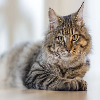

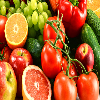

Secret Message: ATtack


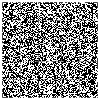

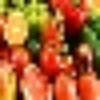

Watermark Data
Decoded message is ATtack
PSNR between original and DCT encoded image: 31.88 dB
NCC value is: 0.7483


In [41]:
from PIL import Image
import numpy as np
import itertools
import types
import cv2
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
import os
import base64
import qrcode
import zxing
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import padding
import ast


import sys
if not hasattr(sys, 'PY_SSIZE_T_CLEAN'):
    sys.PY_SSIZE_T_CLEAN = 1

# Quantization matrix for JPEG compression
# Higher quality factor -> less lossy compression
# makes image easier to encode
quant = np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])

class DiscreteCosineTransform:

    def __init__(self):
        self.message = None
        self.bitMessage = None #binary of secret message
        self.oriCol = 0 #number of columns in input image
        self.oriRow = 0 #number of rows in input image
        self.numBits = 0 #number of binary bits in secret message


    #split data into chunks
    def chunks(self,l,n):
        m = int(n)
        for i in range(0,len(l),m):
            yield l[i:i+m]

    #add padding to make the function dividable by 8x8 blocks
    def addPadd(self,img,row,col):
        img = cv2.resize(img,(col+(8-col%8),row+(8-row%8)))
        return img

    #text to bits
    def toBits(self):
        bits = []
        for char in self.message:
            binval = bin(ord(char))[2:].rjust(8, '0')
            #print('bin '+binval)
            bits.append(binval)
        self.numBits = bin(len(bits))[2:].rjust(8,'0')
        return bits


    def DCTEncoder(self,img,secret):
        self.message = str(len(secret)) + '*' + secret
        self.bitMessage = [str(bit) for bit in self.toBits()]

        row, col = img.shape[:2]
        self.oriRow = row
        self.oriCol = col

        #check if message is too large to embed in image
        if((col/8)*(row/8)<len(secret)):
            print("Error: Message too large to embedd in image")
            return False

        #add padding
        if(row%8!=0 or col%8!=0):
            img = self.addPadd(img,row,col)
        row,col = img.shape[:2]

        #split image into RGB channels
        bImg,gImg,rImg = cv2.split(img)

        #message to be hide in blue channel so converted to type float32 for dct function
        bImg = np.float32(bImg)

        #breaking the image into 8x8 blocks
        imgBlocks = [np.round(bImg[j:j+8,i:i+8]-128) for (j,i) in itertools.product(range(0,row,8),range(0,col,8))]

        #print(imgBlocks[0])
        #apply dct to each blocks
        dctBlocks = [np.round(cv2.dct(ib)) for ib in imgBlocks]

        #apply quantization to each block and obtain quant coefficients
        quantDCT = [np.round(dbk/quant) for dbk in dctBlocks]

        #set LSB in DC value [low freq] corresponding bit of message
        messIndex=0
        letterIndex=0

        for qb in quantDCT:
            #find LSB in DCT cofficient and replace it with message bit
            DC = qb[0][0]
            DC = np.uint8(DC)
            DC = np.unpackbits(DC)
            DC[7] = self.bitMessage[messIndex][letterIndex] #encode
            DC = np.packbits(DC)
            DC = np.float32(DC)
            DC = DC - 255
            qb[0][0] = DC
            letterIndex = letterIndex + 1
            if (letterIndex == 8):
                letterIndex = 0
                messIndex = messIndex + 1
                if (messIndex == len(self.message)):
                    break

        #inverse quantization
        sImgBlocks = [quantizedBlock *quant+128 for quantizedBlock in quantDCT]

       #reconsruct the image
        sImg=[]
        for chunkRowBlocks in self.chunks(sImgBlocks, col/8):
            for rowBlockNum in range(8):
                for block in chunkRowBlocks:
                    sImg.extend(block[rowBlockNum])

        sImg = np.array(sImg).reshape(row, col)

        sImg = np.uint8(sImg)

        #generate final image
        sImg = cv2.merge((sImg,gImg,rImg))
        return sImg

    def DCTDecoder(self, img):
      row, col = img.shape[:2]
      messSize = None
      messageBits = []
      buff = 0

      # split the image into RGB channels
      bImg, gImg, rImg = cv2.split(img)

      # message hid in the blue channel so converted to type float32 for dct function
      bImg = np.float32(bImg)

      # break into 8x8 blocks
      imgBlocks = [bImg[j:j + 8, i:i + 8] - 128 for (j, i) in itertools.product(range(0, row, 8), range(0, col, 8))]
      quantDCT = [ib / quant for ib in imgBlocks]
      i = 0
      flag = 0
      nb = '' #stores decoded bits
      for qb in quantDCT:
          DC = qb[0][0]
          DC = np.uint8(DC)
          DC = np.unpackbits(DC)
          if flag == 0:
              if DC[7] == 1:
                  buff += (0 & 1) << (7 - i)
              elif DC[7] == 0:
                  buff += (1 & 1) << (7 - i)
          else:
              if DC[7] == 1:
                  nb += '0'
              elif DC[7] == 0:
                  nb += '1'
          i = 1 + i
          if i == 8:
              if flag == 0:
                  #done embedding
                  messageBits.append(buff)
                  buff = 0
              else:
                  #done decoding
                  messageBits.append(nb)
                  nb = ''
              i = 0
              if messageBits[-1] == 42 and messSize is None:
                  try:
                      flag = 1
                      messSize = int(str(chr(messageBits[0])) + str(chr(messageBits[1])))
                  except:
                      pass
          if len(messageBits) - len(str(messSize)) - 1 == messSize:
              return messageBits

      # inverse quantization
      sImgBlocks = [qb * quant + 128 for qb in quantDCT]
      sImg = []

      #generate image
      for chunkRowBlocks in self.chunks(sImgBlocks, col / 8):
          for rowBlockNum in range(8):
              for block in chunkRowBlocks:
                  sImg.extend(block[rowBlockNum])
      sImg = np.array(sImg).reshape(row, col)
      sImg = np.uint8(sImg)
      sImg = cv2.merge((sImg, gImg, rImg))
      return messageBits

def aes_encrypt(message, key):
    # Pad the message to be a multiple of 16 bytes
    if len(message) % 16 != 0:
        message += ' ' * (16 - len(message) % 16)

    # Create a cipher object using the key
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    # Encrypt the message
    enc_msg = encryptor.update(message.encode()) + encryptor.finalize()
    return enc_msg

def aes_decrypt(ctext, key):
    # Create a cipher object using the key
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()

    # Decrypt the message
    dec_msg = decryptor.update(ctext) + decryptor.finalize()
    return dec_msg.decode().rstrip()

def base64_to_image(base64_str, output_path):
    image_bytes = base64.b64decode(base64_str)
    image_nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(image_nparr, cv2.IMREAD_COLOR)
    cv2.imwrite(output_path, image)

    img_resized = cv2.resize(image, (100, 100))
    cv2_imshow(img_resized)
    print("Watermark Data")

    return output_path

def image_to_base64(img_path, resize_dim=(25, 25)):
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, resize_dim)

    _, buffer = cv2.imencode('.jpg', image_resized)
    image_base64 = base64.b64encode(buffer).decode('utf-8')

    return image_base64

def generate_qr_code_with_image(message, image_path, filename):
    image_base64 = image_to_base64(image_path)
    combined_data = image_base64 + "|||" + message  # Use a separator to differentiate the image and message
    return generate_qr_code(combined_data, filename)

# create a QR code from a message
def generate_qr_code(message, filename):
    qr = qrcode.QRCode(
        version=None,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(message)
    qr.make(fit=True)
    qr_img_path = filename
    qr_img = qr.make_image(fill_color="black", back_color="white")
    qr_img.save(qr_img_path)
    return qr_img_path

def decode_qr_with_zxing(image_path):
    reader = zxing.BarCodeReader()
    barcode = reader.decode(image_path)
    if barcode is not None:
        return barcode.raw
    return None

def decode_qr_code_with_image(filename):
    decoded_data = decode_qr_with_zxing(filename)
    # print(decoded_data.count("|||"))
    if "|||" not in decoded_data:
        raise ValueError("The decoded data does not contain the expected separator.")
    image_base64, encrypted_message = decoded_data.split("|||")  # Use the separator to split the data
    image_path = base64_to_image(image_base64, f"extracted_watermark_{filename}.png")
    return image_path, encrypted_message

def psnr(orig, watermarked):
    mse = np.mean((orig - watermarked) ** 2)
    if(mse == 0):
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def ncc(orig, stego):
    mean_orig = np.mean(orig)
    mean_stego = np.mean(stego)
    norm_orig = orig - mean_orig
    norm_stego = stego - mean_stego
    ncc = (np.mean(norm_orig * norm_stego)) / (np.std(norm_orig) * np.std(norm_stego))
    return ncc

salt = os.urandom(16)
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=16,  # 16 bytes for AES-128
    salt=salt,
    iterations=100000,
    backend=default_backend()
)

watermark_img_name = input("Enter Watermark Image Name: ")
img_name = input("Enter Image Name: ")

image = cv2.imread(img_name,cv2.IMREAD_UNCHANGED)
img_resize = cv2.resize(image, (100, 100))
cv2_imshow(img_resize)

watermark_image = cv2.imread(watermark_img_name,cv2.IMREAD_UNCHANGED)
wm_resize = cv2.resize(watermark_image, (100, 100))
cv2_imshow(wm_resize)

secret_msg = input("Secret Message: ")

secret_msg_bytes = secret_msg.encode()
key = kdf.derive(secret_msg_bytes)
encrypted_msg_bytes = aes_encrypt(secret_msg, key)
encrypted_msg = str(aes_encrypt(secret_msg, key))

# print('AES MSG BYTES: ',encrypted_msg_bytes)

qr_img_path = generate_qr_code_with_image(encrypted_msg, watermark_img_name, f"qr_code_of_{img_name}_DCT.png")
qr_img = cv2.imread(qr_img_path)
qr_resized = cv2.resize(qr_img, (100, 100))
cv2_imshow(qr_resized)

extracted_image_path, encrypted_message_base64_with_image = decode_qr_code_with_image(qr_img_path)

# print(encrypted_msg)
d = DiscreteCosineTransform()
"""sm = str(enc_msg)
sm = sm[1:]
print('sm',sm)"""
dct_img_encoded = d.DCTEncoder(image, encrypted_message_base64_with_image)
cv2.imwrite(f'watermarked_{img_name}_DCT.png',dct_img_encoded)
eimg = cv2.imread(f'watermarked_{img_name}_DCT.png',cv2.IMREAD_UNCHANGED)

text = d.DCTDecoder(eimg)
ntext = []
# print("Text by DCTDecoder: ",text)
for i in range(len(text)):
    if(type(text[i]) == str):
        ntext.append(text[i])

decoded_data = b''
for byte in ntext:
    try:
        byte_value = int(byte, 2)
        decoded_data += byte_value.to_bytes((byte_value.bit_length() + 7) // 8, byteorder='big')
    except Exception as e:
        # Handle exceptions if needed
        break
# print(decoded_data)

bytes_value = ast.literal_eval(decoded_data.decode())

dtext = aes_decrypt(bytes_value, key)

print("Decoded message is "+dtext)

resized = cv2.resize(dct_img_encoded, (image.shape[1], image.shape[0]))
psnr_value = psnr(image, resized)
print(f"PSNR between original and DCT encoded image: {psnr_value:.2f} dB")

ncc_value = ncc(image, resized)
print(f"NCC value is: {ncc_value:.4f}")


## DWT

Enter Watermark Image: watermark.jpg
Enter Image: cat.jpg


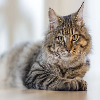

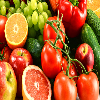

Enter Secret Message: Attck


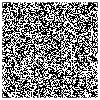

Decoded message is Attck
PSNR value between original and watermarked image: 77.44 dB
NCC value is: 1.0000


In [40]:
import cv2
import numpy as np
import pywt
import base64
import qrcode
import zxing
import os
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from google.colab.patches import cv2_imshow

def text_to_bin(text):
    return ''.join(format(ord(c), '08b') for c in text)

def bin_to_text(binary):
    text = ''.join(chr(int(binary[i:i+8], 2)) for i in range(0, len(binary), 8))
    return text

def embed_text_in_channel(channel, text):
    n_bits = len(text)
    index = 0

    coeffs = pywt.dwt2(channel, 'haar')
    LL, (LH, HL, HH) = coeffs

    # embedd in lower freq
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if index < n_bits:
                pixel = LL[i, j]
                pixel = int(pixel) & ~1 | int(text[index])
                LL[i, j] = pixel
                index += 1

    coeffs = LL, (LH, HL, HH)
    return pywt.idwt2(coeffs, 'haar')

def embed_text(image, text):
    R, G, B = cv2.split(image)
    embedded_R = embed_text_in_channel(R, text)
    embedded_G = embed_text_in_channel(G, text)
    embedded_B = embed_text_in_channel(B, text)
    return cv2.merge((embedded_R, embedded_G, embedded_B))

def extract_text_from_channel(channel, length):
    coeffs = pywt.dwt2(channel, 'haar')
    LL, _ = coeffs

    binary = ''
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if len(binary) < length:
                binary += str(int(LL[i, j]) & 1)

    return binary

def aes_encrypt(message, key):
    # Pad the message to be a multiple of 16 bytes
    if len(message) % 16 != 0:
        message += ' ' * (16 - len(message) % 16)

    # Create a cipher object using the key
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    # Encrypt the message
    enc_msg = encryptor.update(message.encode()) + encryptor.finalize()
    return enc_msg

def aes_decrypt(ctext, key):
    # Create a cipher object using the key
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()

    # Decrypt the message
    dec_msg = decryptor.update(ctext) + decryptor.finalize()
    return dec_msg.decode().rstrip()

def extract_text(image, length):
    R, G, B = cv2.split(image)
    binary_text = extract_text_from_channel(R, length)
    return bin_to_text(binary_text)

def base64_to_image(base64_str, output_path):
    image_bytes = base64.b64decode(base64_str)
    image_nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(image_nparr, cv2.IMREAD_COLOR)
    cv2.imwrite(output_path, image)
    return output_path

def image_to_base64(img_path, resize_dim=(25, 25)):
    # Read and resize the image
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, resize_dim)

    # Convert the image to base64
    _, buffer = cv2.imencode('.jpg', image_resized)
    image_base64 = base64.b64encode(buffer).decode('utf-8')

    return image_base64

def generate_qr_code_with_image(message, image_path, filename):
    image_base64 = image_to_base64(image_path)
    combined_data = image_base64 + "|||" + message  # Use a separator to differentiate the image and message
    return generate_qr_code(combined_data, filename)

# Function to create a QR code from a message
def generate_qr_code(message, filename):
    qr = qrcode.QRCode(
        version=None,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(message)
    qr.make(fit=True)
    qr_img_path = filename
    qr_img = qr.make_image(fill_color="black", back_color="white")
    qr_img.save(qr_img_path)
    return qr_img_path

def decode_qr_with_zxing(image_path):
    reader = zxing.BarCodeReader()
    barcode = reader.decode(image_path)
    if barcode is not None:
        return barcode.raw
    return None

def decode_qr_code_with_image(filename):
    decoded_data = decode_qr_with_zxing(filename)
    # print(decoded_data.count("|||"))
    if "|||" not in decoded_data:
        raise ValueError("The decoded data does not contain the expected separator.")
    image_base64, encrypted_message = decoded_data.split("|||")  # Use the separator to split the data
    image_path = base64_to_image(image_base64, f"extracted_watermark_{filename}.png")
    return image_path, encrypted_message

def psnr(orig, watermarked):
    mse = np.mean((orig - watermarked) ** 2)
    if(mse == 0):
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def ncc(orig, stego):
    mean_orig = np.mean(orig)
    mean_stego = np.mean(stego)
    norm_orig = orig - mean_orig
    norm_stego = stego - mean_stego
    ncc = (np.mean(norm_orig * norm_stego)) / (np.std(norm_orig) * np.std(norm_stego))
    return ncc

salt = os.urandom(16) # for better security
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=16,  # 16 bytes for AES-128
    salt=salt,
    iterations=100000,
    backend=default_backend()
)

wmark_img_name = input("Enter Watermark Image: ")
watermark_img = cv2.imread(wmark_img_name)

img_name = input("Enter Image: ")
_img = cv2.imread(img_name)

img_resize = cv2.resize(_img, (100, 100))
cv2_imshow(img_resize)

wm_resize = cv2.resize(watermark_img, (100, 100))
cv2_imshow(wm_resize)

secret_message = input("Enter Secret Message: ")
secret_msg_bytes = secret_message.encode()
key = kdf.derive(secret_msg_bytes)
encrypted_msg_bytes = aes_encrypt(secret_message, key)
encrypted_msg = str(aes_encrypt(secret_message, key))

qr_img_path= generate_qr_code_with_image(encrypted_msg,wmark_img_name,f"qr_code_of_{img_name}_DWT.png")
qr_img = cv2.imread(qr_img_path)
qr_resized = cv2.resize(qr_img, (100, 100))
cv2_imshow(qr_resized)

extracted_image_path, encrypted_message_base64_with_image = decode_qr_code_with_image(qr_img_path)

binary_text = text_to_bin(encrypted_message_base64_with_image)

embedded_image = embed_text(_img, binary_text)
output_path = f"watermarked_{img_name}_DWT.jpg"
cv2.imwrite(output_path, embedded_image)

extracted_binary_length = len(binary_text)
extracted_text = extract_text(embedded_image, extracted_binary_length)

extracted_image_path, encrypted_message_base64_with_image = decode_qr_code_with_image(qr_img_path)

decrypted_message = aes_decrypt(encrypted_msg_bytes, key)

print("Decoded message is "+decrypted_message)

psnr_value = psnr(_img, embedded_image)
print(f"PSNR value between original and watermarked image: {psnr_value:.2f} dB")

ncc_value = ncc(_img, embedded_image)
print(f"NCC value is: {ncc_value:.4f}")